In [19]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scikeras.wrappers import KerasRegressor
import os

In [21]:
import joblib

X_train = joblib.load("models_daily/X_train.pkl")
X_val   = joblib.load("models_daily/X_val.pkl")
X_test  = joblib.load("models_daily/X_test.pkl")

y_train = joblib.load("models_daily/y_train.pkl")
y_val   = joblib.load("models_daily/y_val.pkl")
y_test  = joblib.load("models_daily/y_test.pkl")

X_train_scaled = joblib.load("models_daily/X_train_scaled.pkl")
X_val_scaled   = joblib.load("models_daily/X_val_scaled.pkl")
X_test_scaled  = joblib.load("models_daily/X_test_scaled.pkl")


In [23]:
from sklearn.preprocessing import StandardScaler
import joblib

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled   = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1))

joblib.dump(y_scaler, "models_daily/y_scaler.pkl")

['models_daily/y_scaler.pkl']

In [4]:
numeric_cols = X_train.select_dtypes(include=["float64", "int64"]).columns

#eksik doldurma sadece train seti ortalamasıyla yapıldı
fill_values = X_train[numeric_cols].mean()

X_train = X_train.fillna(fill_values)
X_val   = X_val.fillna(fill_values)
X_test  = X_test.fillna(fill_values)

In [5]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib
import os

def build_model(hidden_units=(128, 64, 32), dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))

    for units in hidden_units:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))  # Linear çıkış
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [6]:
# earlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

#hiperparametre search alanı
param_dist = {
    "model__hidden_units": [(128, 64, 32), (64, 32), (128, 128), (64, 64, 32)],
    "model__dropout_rate": [0.1, 0.2, 0.3],
    "model__learning_rate": [1e-3, 5e-4, 1e-4],
    "batch_size": [32, 64, 128]
}

reg = KerasRegressor(
    model=build_model,
    verbose=0,
    epochs=100,
    callbacks=[early_stop],
    random_state=42,
    validation_split=0.15
)

tscv = TimeSeriesSplit(n_splits=3)

In [7]:
#random search
random_search = RandomizedSearchCV(
    estimator=reg,
    param_distributions=param_dist,
    n_iter=10,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=-1,
    random_state=42
)


In [8]:
random_search.fit(X_train_scaled, y_train_scaled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.


,estimator,KerasRegresso... epochs=100 )
,param_distributions,"{'batch_size': [32, 64, ...], 'model__dropout_rate': [0.1, 0.2, ...], 'model__hidden_units': [(128, ...), (64, ...), ...], 'model__learning_rate': [0.001, 0.0005, ...]}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [9]:
best_model = random_search.best_estimator_.model_
val_pred_scaled = best_model.predict(X_val_scaled)
val_pred = y_scaler.inverse_transform(val_pred_scaled)

rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print("\nEn iyi hiperparametreler:")
print(random_search.best_params_)
print(f"Optimize edilmiş model RMSE (orijinal ölçekte): {rmse:.2f}")

170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

En iyi hiperparametreler:
{'model__learning_rate': 0.0005, 'model__hidden_units': (64, 32), 'model__dropout_rate': 0.1, 'batch_size': 32}
Optimize edilmiş model RMSE (orijinal ölçekte): 6.98


In [10]:
os.makedirs("models_daily", exist_ok=True)
best_model.save("models_daily/mlp_model_tuned.keras")

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, model_name="Model"):
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()

    epsilon = 1e-6
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + epsilon))
    corr = np.corrcoef(y_true, y_pred)[0, 1]

    print(f"\n{model_name} Değerlendirme Metrikleri:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"SMAPE: {smape:.2f}%")
    print(f"Pearson Corr: {corr:.4f}")


In [41]:
val_pred_scaled = best_model.predict(X_val_scaled)
val_pred_scaled = np.array(val_pred_scaled).ravel()
bad_mask = (val_pred_scaled > 1e3) | (val_pred_scaled < -1e3)

val_pred_clean = val_pred_scaled[~bad_mask]
y_val_clean = y_val.values.ravel()[~bad_mask]

val_pred_unscaled = y_scaler.inverse_transform(val_pred_clean.reshape(-1, 1)).ravel()

evaluate_model(y_val_clean, val_pred_unscaled, model_name="MLP (Daily)")


170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

MLP (Daily) Değerlendirme Metrikleri:
MAE: 5.34
RMSE: 6.98
R²: 0.5779
MAPE: 10.86%
SMAPE: 10.10%
Pearson Corr: 0.7639


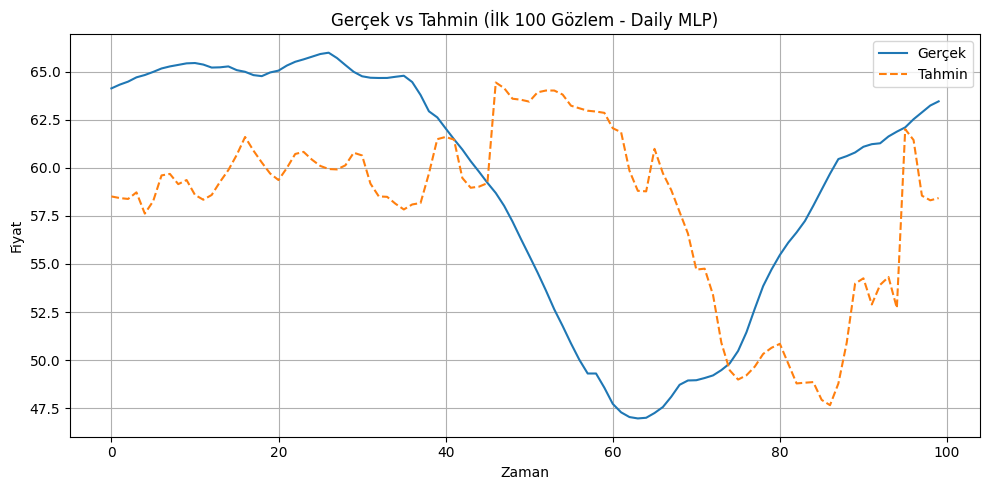

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_val_clean[:100], label="Gerçek")
plt.plot(val_pred_unscaled[:100], label="Tahmin", linestyle="--")
plt.title("Gerçek vs Tahmin (İlk 100 Gözlem - Daily MLP)")
plt.xlabel("Zaman")
plt.ylabel("Fiyat")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


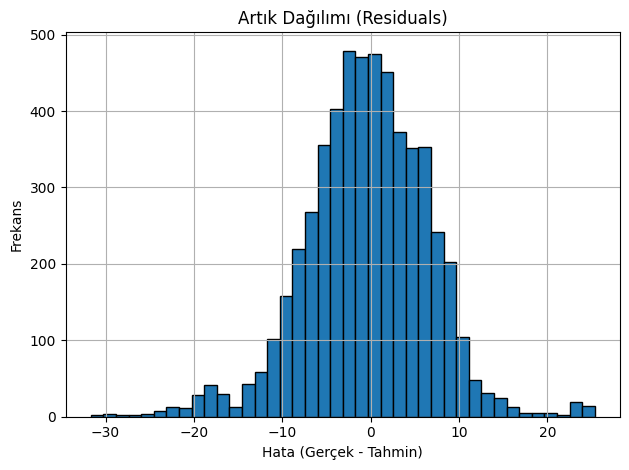

In [45]:
residuals = y_val_clean - val_pred_unscaled
plt.hist(residuals, bins=40, edgecolor='k')
plt.title("Artık Dağılımı (Residuals)")
plt.xlabel("Hata (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import joblib
import numpy as np

In [49]:
lgbm = LGBMRegressor(random_state=42)

In [51]:
#hiperparametre arama alanı
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [53]:
tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [55]:
search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6107
[LightGBM] [Info] Number of data points in the train set: 25354, number of used features: 30
[LightGBM] [Info] Start training from score 55.521636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,estimator,LGBMRegressor(random_state=42)
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [-1, 5, ...], 'min_child_samples': [10, 20, ...], ...}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [59]:
#validation ve RMSE hesaplama orijinal ölçekte
best_lgbm = search.best_estimator_
joblib.dump(best_lgbm, "models_daily/lgbm_model.pkl")


['models_daily/lgbm_model.pkl']

In [61]:
best_lgbm = joblib.load("models_daily/lgbm_model.pkl")
X_val = joblib.load("models_daily/X_val.pkl")
y_val = joblib.load("models_daily/y_val.pkl")

val_pred = best_lgbm.predict(X_val)

# Uç tahminleri filtreliyoruz
val_pred = np.array(val_pred).reshape(-1, 1)
bad_mask = (val_pred > 1e3) | (val_pred < -1e3)

val_pred_clean_lgbm = val_pred[~bad_mask.flatten()]
y_val_clean_lgbm = y_val.values[~bad_mask.flatten()]


In [63]:
evaluate_model(y_val_clean_lgbm, val_pred_clean_lgbm, model_name="LightGBM")


LightGBM Değerlendirme Metrikleri:
MAE: 4.38
RMSE: 6.04
R²: 0.6837
MAPE: 9.37%
SMAPE: 8.47%
Pearson Corr: 0.8286


In [65]:
X_train = joblib.load("models_daily/X_train.pkl")
y_train = joblib.load("models_daily/y_train.pkl")
X_val = joblib.load("models_daily/X_val.pkl")
y_val = joblib.load("models_daily/y_val.pkl")

In [69]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}


tscv = TimeSeriesSplit(n_splits=3)

# Randomized Search
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)


In [71]:
search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [None, 5, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [72]:
best_rf = search.best_estimator_
joblib.dump(best_rf, "models_daily/rf_model.pkl")

print("En iyi hiperparametreler:")
print(search.best_params_)

En iyi hiperparametreler:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}


In [73]:
best_rf = joblib.load("models_daily/rf_model.pkl")

val_pred = best_rf.predict(X_val)
val_pred = np.array(val_pred).reshape(-1, 1)

# Uç tahmin temizliği
bad_mask = (val_pred > 1e3) | (val_pred < -1e3)
val_pred_clean_rf = val_pred[~bad_mask.flatten()]
y_val_clean_rf = y_val.values[~bad_mask.flatten()]

In [74]:
evaluate_model(y_val_clean_rf, val_pred_clean_rf, model_name="Random Forest")



Random Forest Değerlendirme Metrikleri:
MAE: 4.86
RMSE: 6.63
R²: 0.6193
MAPE: 10.35%
SMAPE: 9.26%
Pearson Corr: 0.7903


In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def collect_metrics(y_true, y_pred):
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    corr = np.corrcoef(y_true, y_pred)[0, 1]

    return [mae, rmse, r2, mape, smape, corr]


In [83]:
mlp_metrics = collect_metrics(y_val_clean, val_pred_unscaled,)
lgbm_metrics = collect_metrics(y_val_clean_lgbm, val_pred_clean_lgbm)
rf_metrics   = collect_metrics(y_val_clean_rf, val_pred_clean_rf)


In [85]:
results = pd.DataFrame(
    [mlp_metrics, lgbm_metrics, rf_metrics],
    columns=["MAE", "RMSE", "R²", "MAPE (%)", "SMAPE (%)", "Pearson Corr"],
    index=["MLP (Clean)", "LightGBM (Clean)", "Random Forest (Clean)"]
)

print("\nModel Karşılaştırma Tablosu:")
display(results.round(4))



Model Karşılaştırma Tablosu:


,MAE,RMSE,R²,MAPE (%),SMAPE (%),Pearson Corr
MLP (Clean),5.3385,6.9778,0.5779,10.8624,10.0990,0.7639
LightGBM (Clean),4.3825,6.0398,0.6837,9.3694,8.4669,0.8286
Random Forest (Clean),4.8636,6.6270,0.6193,10.3497,9.2630,0.7903


In [1]:
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
model = joblib.load("models_daily/lgbm_model.pkl")
X_val = joblib.load("models_daily/X_val.pkl")

In [3]:
explainer = shap.Explainer(model)

shap_values = explainer(X_val)


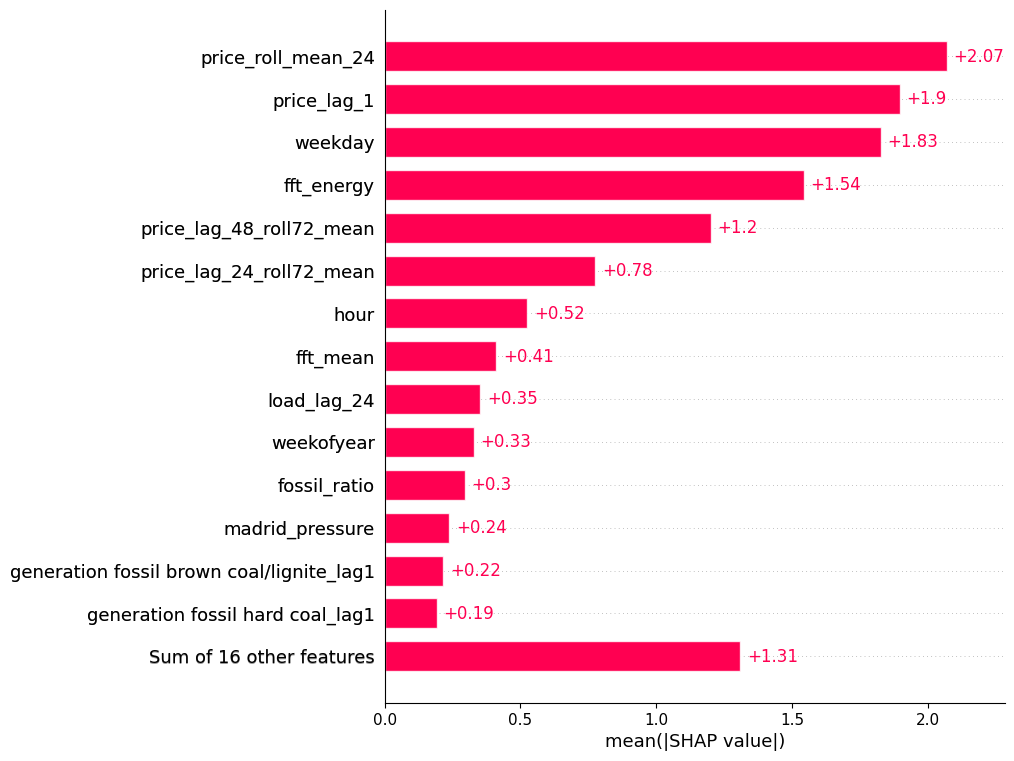

In [4]:
shap.plots.bar(shap_values, max_display=15)

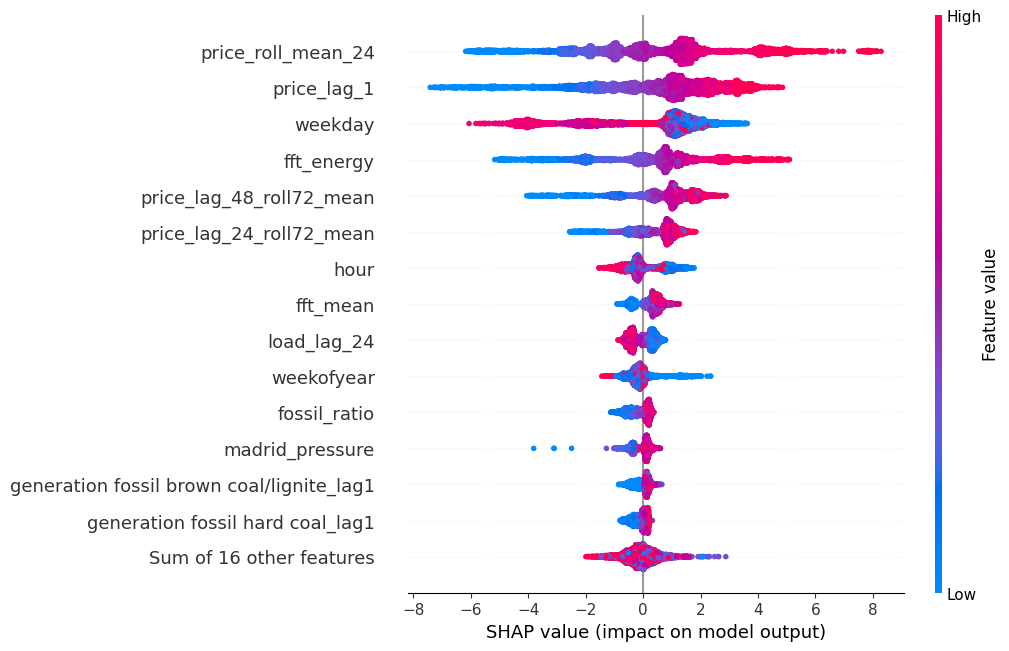

In [5]:
shap.plots.beeswarm(shap_values, max_display=15)

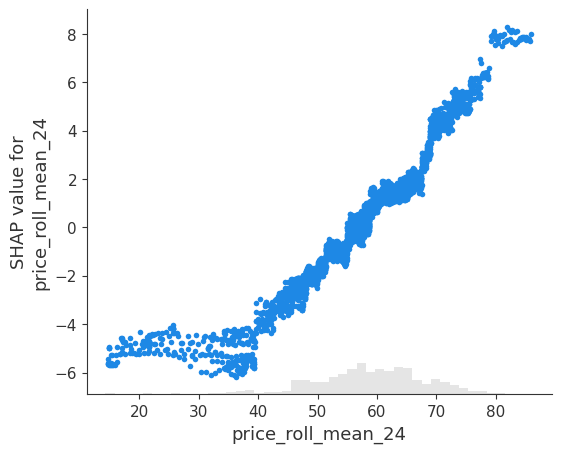

In [6]:
shap.plots.scatter(shap_values[:, "price_roll_mean_24"])

In [27]:
from tensorflow.keras.models import load_model

mlp_model = load_model("models_daily/mlp_model_tuned.keras")
lgbm_model = joblib.load("models_daily/lgbm_model.pkl")
rf_model   = joblib.load("models_daily/rf_model.pkl")

val_pred_mlp = mlp_model.predict(X_val_scaled)         # MLP için
val_pred_lgbm = lgbm_model.predict(X_val)              # LightGBM için
val_pred_rf = rf_model.predict(X_val)                  # Random Forest için

mlp_preds = np.array(val_pred_mlp).reshape(-1)
lgbm_preds = np.array(val_pred_lgbm).reshape(-1)
rf_preds = np.array(val_pred_rf).reshape(-1)
y_true = np.array(y_val).reshape(-1)

print("MLP:", mlp_preds.shape)
print("LGBM:", lgbm_preds.shape)
print("RF:", rf_preds.shape)
print("y_val:", y_true.shape)


170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MLP: (5433,)
LGBM: (5433,)
RF: (5433,)
y_val: (5433,)


In [33]:
val_pred_scaled = mlp_model.predict(X_val_scaled)
val_pred_unscaled = y_scaler.inverse_transform(val_pred_scaled.reshape(-1, 1)).ravel()
mlp_preds = val_pred_unscaled

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


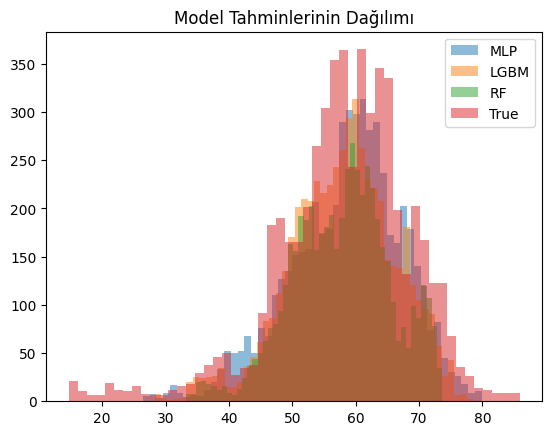

In [35]:
import matplotlib.pyplot as plt

plt.hist(mlp_preds, bins=50, alpha=0.5, label='MLP')
plt.hist(lgbm_preds, bins=50, alpha=0.5, label='LGBM')
plt.hist(rf_preds, bins=50, alpha=0.5, label='RF')
plt.hist(y_true, bins=50, alpha=0.5, label='True')
plt.legend()
plt.title("Model Tahminlerinin Dağılımı")
plt.show()

In [37]:
best_rmse = float("inf")
best_weights = (0, 0, 0)

for w1 in np.arange(0, 1.05, 0.05):
    for w2 in np.arange(0, 1.05 - w1, 0.05):
        w3 = 1.0 - w1 - w2
        if w3 < 0 or w3 > 1:
            continue

        ensemble_pred = w1 * mlp_preds + w2 * lgbm_preds + w3 * rf_preds
        rmse = np.sqrt(mean_squared_error(y_true, ensemble_pred))

        if rmse < best_rmse:
            best_rmse = rmse
            best_weights = (w1, w2, w3)

print(f"En iyi ağırlıklar: {best_weights}")
print(f"Ensemble RMSE: {best_rmse:.4f}")


En iyi ağırlıklar: (np.float64(0.0), np.float64(1.0), np.float64(0.0))
Ensemble RMSE: 6.0398


In [39]:
joblib.dump(best_weights, "models_daily/ensemble_weights.pkl")


['models_daily/ensemble_weights.pkl']

Model çıktıları üzerinden yapılan ağırlık optimizasyonu sonucunda sadece LightGBM modeli ağırlık aldı (`weight = 1.0`), diğer modellerin (MLP, Random Forest) ağırlıkları sıfır oldu.

Bu durum, ensemble yapı kurulmuş olsa bile en iyi performansı tek başına LightGBM modelinin verdiğini gösteriyor. Diğer modellerin katkısı, hata değerlerini artırdığı için en uygun çözüm, sadece LightGBM tahminlerini kullanmak olmuş.

Bu tür bir sonuç, diğer modellerin aşırı öğrenme yapmış olabileceğini ya da LightGBM'in veriyle daha uyumlu çalıştığını düşündürüyor. Sonuç olarak, ensemble yapısı da aslında en iyi modeli dolaylı olarak seçmiş oldu.